In real life, humans use information from text and title to determine if a piece of news is fake or not




In the previous models, we mostly depended on the word type and frequency, but did not use the meaning and order of words to determine the veracity of the news




Using Deep Learning, We can perform this, with the use of Attention Mechanisms and word embeddings




What is BERT?


![Alt text](https://www.researchgate.net/publication/358239462/figure/fig2/AS:1120931644747777@1644262338087/The-DistilBERT-model-architecture-and-components.png "BERT Architecture")




BERT (Bidirectional Encoder Representations from Transformers) is a method of pretraining language representations that was used to create models that NLP practitioners can then download and use for free. We use these models to extract high quality language features from your text data, and fine-tune these models on our classification problem with our data to produce state of the art predictions.




We decided to use DistillBERT, as BERT architecture allows for Bidirectional Encoding of the text, which should improve classification compared to other forms of Encoding like TD-IDF or other Neural Net based Unidirectional Encodings like Word2Vec or Glove. 




For example, given two sentences: "The man was accused of robbing a bank." "The man went fishing by the bank of the river."  Embeddings like Word2Vec and TDIDF would produce the same word embedding for the word "bank" in both sentences, while under BERT the word embedding for "bank" would be different for each sentence which is more in line with the meaning of the sentence.




As BERT also comes with a variety of versions, we decided to use DistillBERT, a smaller model with similar accuracy , given the relatively smaller size of the dataset to prevent excessive overfitting and the computational time limit of 12hours on Kaggle




In this project, we applied Transfer Learning, using a Encoder and Model Trained on Wikipedia pages. We hypothesize that such a approach should be the most effective, given that detection of fake news require a deep existing knowledge base, which the pretrained model weights should reflect




We Freeze the weights and add a SoftMax layer to obtain a classifier which outputs 0 and 1 (Not done yet) 




Due to lack of computational time, we are unable to do automated hyperparameter tuning experiments, but found that the default hyperparameters was able to produce state of the art results on both the testing and validation results, with the model slightly underfitting which means that the model was effective in producing a generalization of the data.






In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
import torch
import os
from transformers import BertTokenizer, TFBertModel,BertForSequenceClassification,DistilBertTokenizerFast,DistilBertModel, Trainer, TrainingArguments,DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-04-19 17:43:30.057401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 17:43:30.057507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 17:43:30.190531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/bert-trained/transformers/news_complete/1/config.json
/kaggle/input/bert-trained/transformers/news_complete/1/trainer_state.json
/kaggle/input/bert-trained/transformers/news_complete/1/training_args.bin
/kaggle/input/bert-trained/transformers/news_complete/1/scheduler.pt
/kaggle/input/bert-trained/transformers/news_complete/1/model.safetensors
/kaggle/input/bert-trained/transformers/news_complete/1/optimizer.pt
/kaggle/input/bert-trained/transformers/news_complete/1/rng_state.pth
/kaggle/input/sc1005-news/True.csv
/kaggle/input/sc1005-news/Fake.csv


In [2]:
true = pd.read_csv('/kaggle/input/sc1005-news/True.csv')
false = pd.read_csv('/kaggle/input/sc1005-news/Fake.csv')

In [3]:
# Add a 'truth' column to each dataframe with the appropriate values
true['label'] = 1
false['label'] = 0

# for presentation 
true['label_meaning'] = True 
false['label_meaning'] = False

# Concatenate the two dataframes into a single dataframe
combined_news = pd.concat([true, false], ignore_index=True)

# shuffle the rows
news = combined_news.sample(frac=1).reset_index(drop=True)
news.head()

,title,text,subject,date,label,label_meaning
0,Pakistan's top diplomat pushes back on U.S. cl...,WASHINGTON (Reuters) - Pakistan s foreign mini...,worldnews,"October 5, 2017",1,True
1,Merkel: Strong result for Austria's FPO 'big c...,BERLIN (Reuters) - German Chancellor Angela Me...,worldnews,"October 16, 2017",1,True
2,Stock Market Literally SHUTS DOWN And Dollar ...,The prospect of Donald Trump winning the presi...,News,"November 8, 2016",0,False
3,Trump order to ease ban on political activity ...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"May 3, 2017",1,True
4,NEWT GINGRICH Slams DOJ’s Sessions: “It’s time...,A cesspool of corruption Newt Gingrich cal...,politics,"Dec 15, 2017",0,False


In [4]:
#create new dataframe with title,text,label
news_cleaned = news[['title','text','label']]

Combining the title and the text together in a column 'comb_text'

In [5]:


# Purify by merging the title and text
news_cleaned['comb_text'] = news_cleaned[['title', 'text']].agg(''.join, axis=1)
display(news_cleaned)
# Shuffle to check veracity of cleaning
news_cleaned = shuffle(news_cleaned).reset_index(drop=True)


/tmp/ipykernel_24/1138330582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_cleaned['comb_text'] = news_cleaned[['title', 'text']].agg(''.join, axis=1)


,title,text,label,comb_text
0,Pakistan's top diplomat pushes back on U.S. cl...,WASHINGTON (Reuters) - Pakistan s foreign mini...,1,Pakistan's top diplomat pushes back on U.S. cl...
1,Merkel: Strong result for Austria's FPO 'big c...,BERLIN (Reuters) - German Chancellor Angela Me...,1,Merkel: Strong result for Austria's FPO 'big c...
2,Stock Market Literally SHUTS DOWN And Dollar ...,The prospect of Donald Trump winning the presi...,0,Stock Market Literally SHUTS DOWN And Dollar ...
3,Trump order to ease ban on political activity ...,WASHINGTON (Reuters) - President Donald Trump ...,1,Trump order to ease ban on political activity ...
4,NEWT GINGRICH Slams DOJ’s Sessions: “It’s time...,A cesspool of corruption Newt Gingrich cal...,0,NEWT GINGRICH Slams DOJ’s Sessions: “It’s time...
...,...,...,...,...
44893,SOMEONE CALL THE Waaambulance! Glenn Beck Warn...,"Hey Glenn, suicide is no laughing matter, and ...",0,SOMEONE CALL THE Waaambulance! Glenn Beck Warn...
44894,U.S. military unfunded requirement list at $33...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,1,U.S. military unfunded requirement list at $33...
44895,Bill O’Reilly Appears ‘Stumble Drunk’ As He T...,Fox News veteran Bill O Reilly is being slaugh...,0,Bill O’Reilly Appears ‘Stumble Drunk’ As He T...
44896,Congressional Black Caucus Cries Foul Over Su...,"Earlier this week, following Hillary Clinton s...",0,Congressional Black Caucus Cries Foul Over Su...


In [6]:
news_cleaned = news_cleaned[['comb_text','label']]

In [7]:
df_texts, df_labels = news_cleaned["comb_text"].to_list(),news_cleaned["label"].to_list()

In [8]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df_texts, df_labels, test_size=.3)

In [9]:
model_name = DistilBertModel.from_pretrained("distilbert-base-uncased")
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
#obtain DistillBERT word encodings, and generate key, query, value tensors for training
#Pad to the longest sequence in the batch 
#Truncate to a maximum length specified with the argument max_length or to the maximum acceptable input length for the model. This will truncate token by token, removing a token from the longest sequence in the pair if a pair of sequences (or a batch of pairs) is provided.
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [11]:
#class to return encodings and labels for training
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

In [12]:
def training_compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
 
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [13]:
#function to evaluate test data
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
 
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    # Print the Accuracy Measures from the Confusion Matrix
    cmTest = confusion_matrix(labels.tolist(), preds.tolist())
    tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
    fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
    tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
    fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

    print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
    print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
    print()

    print("FPR Test :\t", (fpTest/(tnTest + fpTest)))
    print("FNR Test :\t", (fnTest/(tpTest + fnTest)))

    # Plot the two-way Confusion Matrix
    sb.heatmap(cmTest, 
               annot = True, fmt=".0f", annot_kws={"size": 18})
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [14]:
#function to evaluate test data
def compute_train_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    # Print the Accuracy Measures from the Confusion Matrix
    cmTrain = confusion_matrix(labels, preds)
    tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
    fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
    tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
    fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

    print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
    print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
    print()

    print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
    print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

    # Plot the two-way Confusion Matrix
    sb.heatmap(cmTrain, 
               annot = True, fmt=".0f", annot_kws={"size": 18})
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [15]:

os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end=True,
    evaluation_strategy ="epoch",
    save_strategy = 'epoch'
)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
'''
for name, param in list(model.named_parameters())[:-3]:  
    print(name)
    param.requires_grad = False
'''
print(f"num params:", model.num_parameters())
print(f"num trainable params:", model.num_parameters(only_trainable=True))
print(model)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    compute_metrics=training_compute_metrics,
    train_dataset=train_dataset,         # training dataset
    eval_dataset=train_dataset,             # evaluation dataset
)



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batc

num params: 66955010
num trainable params: 66955010
DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
  

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.001300,0.002900,0.999205,0.999169,0.998405,0.999933
2,0.000000,0.000400,0.999936,0.999933,1.000000,0.999867
3,0.000000,0.000008,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=5895, training_loss=0.012592639401061357, metrics={'train_runtime': 3433.0112, 'train_samples_per_second': 27.464, 'train_steps_per_second': 1.717, 'total_flos': 1.2489556214882304e+16, 'train_loss': 0.012592639401061357, 'epoch': 3.0})

In [17]:
#load trained model
#obtain saved model from training to evaluate trainset
best_ckpt_path = trainer.state.best_model_checkpoint
print(best_ckpt_path)
self_train_model = DistilBertForSequenceClassification.from_pretrained(best_ckpt_path)

./results/checkpoint-5895


In [18]:
training_trainer = Trainer(
    model=self_train_model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    compute_metrics=compute_train_metrics,
    train_dataset=train_dataset,         # training dataset
    eval_dataset=train_dataset,             # train dataset
)


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


TPR Train :	 1.0
TNR Train :	 1.0

FPR Train :	 0.0
FNR Train :	 0.0


{'eval_loss': 7.603600352013018e-06,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_runtime': 287.4203,
 'eval_samples_per_second': 109.345,
 'eval_steps_per_second': 1.712}

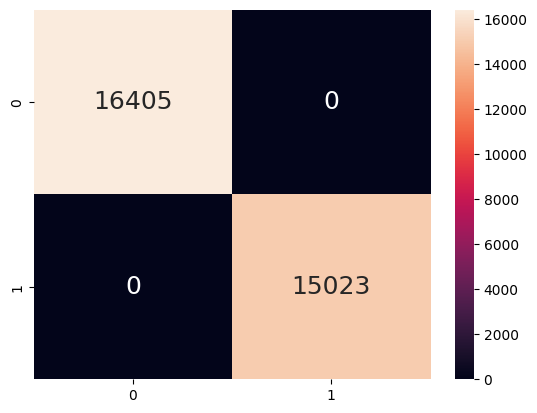

In [19]:
#evaluate on train data
training_trainer.evaluate()

In [20]:
trainer = Trainer(
    model=self_train_model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # train dataset
)


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


TPR Test :	 0.9995308101345011
TNR Test :	 1.0

FPR Test :	 0.0
FNR Test :	 0.00046918986549890525


{'eval_loss': 0.0013302309671416879,
 'eval_accuracy': 0.9997772828507795,
 'eval_f1': 0.9997653500195541,
 'eval_precision': 1.0,
 'eval_recall': 0.9995308101345011,
 'eval_runtime': 123.2472,
 'eval_samples_per_second': 109.293,
 'eval_steps_per_second': 1.712}

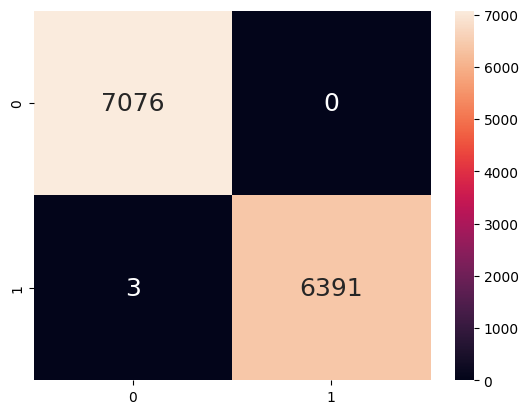

In [21]:
#evaluate on test data
trainer.evaluate()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9215cc77-d380-4a1c-84d3-404198f889a3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>